<a href="https://colab.research.google.com/github/Janet-THY/GA_Projects/blob/main/e-commerce_analysis_time_series_demand_forecasting/codes/04_e_commerce_SQL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Olist E-commerce Analysis using SQL

## Reading and Joining Dataset

---

SQL is best used in connecting/joining multiple tables to perform any analysis. Its important advantages are:


*   recover only specific data
*   preprocessing output upon query
*   scalable, with the same query, same result is recovered as long as the column names are not changed. 
*   less memory is needed. With using 'inner join', we can recover only matching results without altering dataset.

In [1]:
# import libraries
import sqlite3 as sq
import glob
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import iplot
import datetime as dt
import seaborn as sns

from google.colab import drive
# drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/brazilian-ecommerce')


In [2]:
# Step 1: Read the csv file into a dataframe
# Dataset from https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce 
customers_df = pd.read_csv('./datasets/olist_customers_dataset.csv')
orders_df = pd.read_csv('./datasets/olist_orders_dataset.csv')
order_items_df = pd.read_csv('./datasets/olist_order_items_dataset.csv')
products_df = pd.read_csv('./datasets/olist_products_dataset.csv')
product_category_name_translation = pd.read_csv('./datasets/product_category_name_translation.csv')
geolocation_df = pd.read_csv('./datasets/olist_geolocation_dataset.csv')
order_payments_df = pd.read_csv('./datasets/olist_order_payments_dataset.csv')
order_reviews_df = pd.read_csv('./datasets/olist_order_reviews_dataset.csv')
sellers_df = pd.read_csv('./datasets/olist_sellers_dataset.csv')



## SQL Helper Function
useful functions from [source](https://colab.research.google.com/github/stephenleo/medium-python-hacks/blob/main/02_sql_on_colab/main.ipynb#scrollTo=DFHcwKul-30P) 

In [3]:
def pd_to_sqlDB(input_df: pd.DataFrame,
                table_name: str,
                db_name: str = 'default.db') -> None:

    '''Take a Pandas dataframe `input_df` and upload it to `table_name` SQLITE table

    Args:
        input_df (pd.DataFrame): Dataframe containing data to upload to SQLITE
        table_name (str): Name of the SQLITE table to upload to
        db_name (str, optional): Name of the SQLITE Database in which the table is created. 
                                 Defaults to 'default.db'.
    '''

    # Step 1: Setup local logging
    import logging
    logging.basicConfig(level=logging.INFO,
                        format='%(asctime)s %(levelname)s: %(message)s',
                        datefmt='%Y-%m-%d %H:%M:%S')

    # Step 2: Find columns in the dataframe
    cols = input_df.columns
    cols_string = ','.join(cols)
    val_wildcard_string = ','.join(['?'] * len(cols))

    # Step 3: Connect to a DB file if it exists, else crete a new file
    con = sq.connect(db_name)
    cur = con.cursor()
    logging.info(f'SQL DB {db_name} created')

    # Step 4: Create Table
    sql_string = f"""CREATE TABLE {table_name} ({cols_string});"""
    cur.execute(sql_string)
    logging.info(f'SQL Table {table_name} created with {len(cols)} columns')

    # Step 5: Upload the dataframe
    rows_to_upload = input_df.to_dict(orient='split')['data']
    sql_string = f"""INSERT INTO {table_name} ({cols_string}) VALUES ({val_wildcard_string});"""
    cur.executemany(sql_string, rows_to_upload)
    logging.info(f'{len(rows_to_upload)} rows uploaded to {table_name}')
  
    # Step 6: Commit the changes and close the connection
    con.commit()
    con.close()


def sql_query_to_pd(sql_query_string: str, db_name: str ='default.db') -> pd.DataFrame:
    '''Execute an SQL query and return the results as a pandas dataframe

    Args:
        sql_query_string (str): SQL query string to execute
        db_name (str, optional): Name of the SQLITE Database to execute the query in.
                                 Defaults to 'default.db'.

    Returns:
        pd.DataFrame: Results of the SQL query in a pandas dataframe
    '''    
    # Step 1: Connect to the SQL DB
    con = sq.connect(db_name)

    # Step 2: Execute the SQL query
    cursor = con.execute(sql_query_string)

    # Step 3: Fetch the data and column names
    result_data = cursor.fetchall()
    cols = [description[0] for description in cursor.description]

    # Step 4: Close the connection
    con.close()

    # Step 5: Return as a dataframe
    return pd.DataFrame(result_data, columns=cols)

## Upload the dataframe to a SQL Table

In [ ]:
# Step 2: Upload the dataframe to a SQL Table, run for the first time and skip if the table has been created
pd_to_sqlDB(customers_df, table_name='customers_dataset', db_name='capstone.db')
pd_to_sqlDB(orders_df, table_name='orders_dataset', db_name='capstone.db')
pd_to_sqlDB(order_items_df, table_name='order_items_dataset', db_name='capstone.db')
pd_to_sqlDB(products_df, table_name='products_dataset', db_name='capstone.db')
pd_to_sqlDB(product_category_name_translation, table_name='product_category_name_translation', db_name='capstone.db')
pd_to_sqlDB(geolocation_df, table_name='geolocation_dataset', db_name='capstone.db')
pd_to_sqlDB(order_payments_df, table_name='order_payments_dataset', db_name='capstone.db')
pd_to_sqlDB(order_reviews_df, table_name='order_reviews_dataset', db_name='capstone.db')
pd_to_sqlDB(sellers_df, table_name='sellers_dataset', db_name='capstone.db')
 

## Query Execution

## Overview 

### 1.Total Orders and Total Sales Price

In [4]:
# SQL_Query_1
# Step 3: Write the SQL query in a string variable
sql_query_1 = """
    SELECT count(a.order_id) AS Total_Orders, sum(b.price + b.freight_value) AS Total_Sales_Price
    FROM orders_dataset AS a
    INNER JOIN order_items_dataset AS b
    ON a.order_id = b.order_id
    """
 
# Step 4: Exectue the SQL query
result_df_1 = sql_query_to_pd(sql_query_1, db_name='capstone.db')
result_df_1

,Total_Orders,Total_Sales_Price
0,112650,1.584355e+07


From the data given, there are a total of 112650 orders generating total revenue combined sales price and freight value of 15.84 Mil `BR`.

### 2.Number of customers, sellers by state

In [5]:
# Step 3: Write the SQL query in a string variable
sql_query_2 = """
    SELECT count(customer_unique_id) AS N_customers, customer_state AS State
    FROM customers_dataset 
    GROUP BY customer_state
    ORDER BY count()
    """
 
# Step 4: Exectue the SQL query
result_df_2 = sql_query_to_pd(sql_query_2, db_name='capstone.db')
result_df_2

,N_customers,State
0,46,RR
1,68,AP
2,81,AC
3,148,AM
4,253,RO
5,280,TO
6,350,SE
7,413,AL
8,485,RN
9,495,PI


In [6]:
# Step 3: Write the SQL query in a string variable
sql_query_2_1 = """SELECT a.state, a.N_customers, b.N_sellers
                  FROM  (
                        SELECT customer_state AS state, COUNT(DISTINCT customer_unique_id) AS N_customers
                        FROM customers_dataset
                        GROUP BY state 
                        ) AS a
                  INNER JOIN ( 
                        SELECT seller_state AS state, COUNT(DISTINCT seller_id) AS N_sellers
                        FROM sellers_dataset
                        GROUP BY state
                        ) AS b
                  ON a.state = b.state
                  ORDER BY N_customers DESC;""" 
 
# Step 4: Exectue the SQL query
result_df_2_1 = sql_query_to_pd(sql_query_2_1, db_name='capstone.db')
result_df_2_1

,state,N_customers,N_sellers
0,SP,40302,1849
1,RJ,12384,171
2,MG,11259,244
3,RS,5277,129
4,PR,4882,349
5,SC,3534,190
6,BA,3277,19
7,DF,2075,30
8,ES,1964,23
9,GO,1952,40


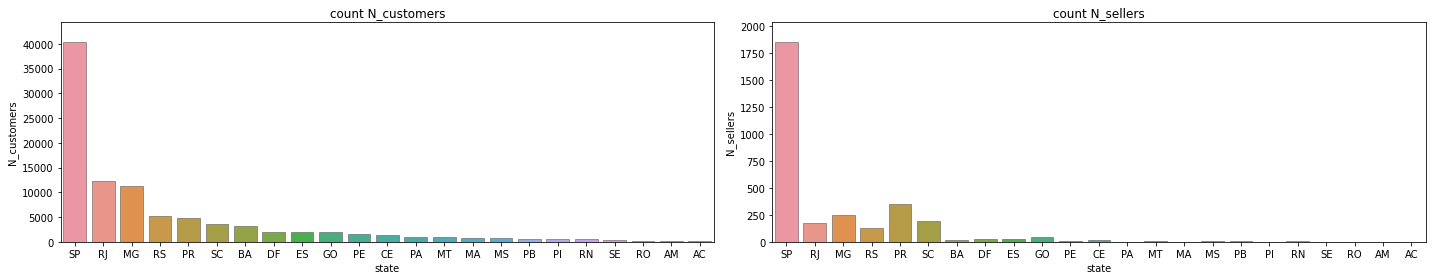

In [7]:
# combined_plot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))
for ax, col in zip(axs, ['N_customers', 'N_sellers']):
    sns.barplot(
        x='state',
        y=col,
        data=result_df_2_1,
        edgecolor=".3",
        linewidth=0.5,
        ci=None,
        ax=ax
    )
    ax.set_title('count ' + col)
    ax.margins(y=0.1) # make room for the labels
    # for bars in ax.containers:
    #     ax.bar_label(bars, fmt='%.1f')
plt.tight_layout()
plt.show()

We observed that generally number of customers are proportionate to the number os sellers (more customers wherever there are more sellers), except for state `PR`. 

### 3.Most common payment method

In [8]:
# SQL_Query_3
# Step 3: Write the SQL query in a string variable
sql_query_3 = """ SELECT a.payment_type, COUNT(a.payment_type) AS count_pay_type, CAST(SUM(a.payment_value) AS int) / 1000 AS 'value_pay_type(K)'
                  FROM order_payments_dataset AS a
                  LEFT JOIN orders_dataset AS b
                  ON a.order_id = b.order_id
                  WHERE b.order_status <> 'canceled' AND b.order_delivered_customer_date IS NOT NULL
                  GROUP BY payment_type
                  ORDER BY count_pay_type DESC;"""

# Step 4: Exectue the SQL query
result_df_3 = sql_query_to_pd(sql_query_3, db_name="capstone.db")
result_df_3

,payment_type,count_pay_type,value_pay_type(K)
0,credit_card,74579,12100
1,boleto,19191,2769
2,voucher,5493,343
3,debit_card,1485,208


In [9]:
# SQL_Query_3_1
# Step 3: Write the SQL query in a string variable
sql_query_3_1 = """ SELECT strftime('%Y-%m', order_purchase_timestamp) AS YearMonth, a.payment_type, COUNT(a.payment_type) AS count_pay_type, 
                          CAST(SUM(a.payment_value) AS int) / 1000 AS 'value_pay_type(K)'
                   FROM order_payments_dataset AS a
                   LEFT JOIN orders_dataset AS b
                   ON a.order_id = b.order_id
                   WHERE b.order_status <> 'canceled' AND b.order_delivered_customer_date IS NOT NULL
                   GROUP BY YearMonth, payment_type
                   ORDER BY YearMonth;"""

# Step 4: Exectue the SQL query
result_df_3_1 = sql_query_to_pd(sql_query_3_1, db_name="capstone.db")
result_df_3_1

,YearMonth,payment_type,count_pay_type,value_pay_type(K)
0,2016-10,boleto,51,7
1,2016-10,credit_card,209,37
2,2016-10,debit_card,2,0
3,2016-10,voucher,20,0
4,2016-12,credit_card,1,0
...,...,...,...,...
80,2018-07,voucher,276,19
81,2018-08,boleto,1119,140
82,2018-08,credit_card,4904,781
83,2018-08,debit_card,270,45


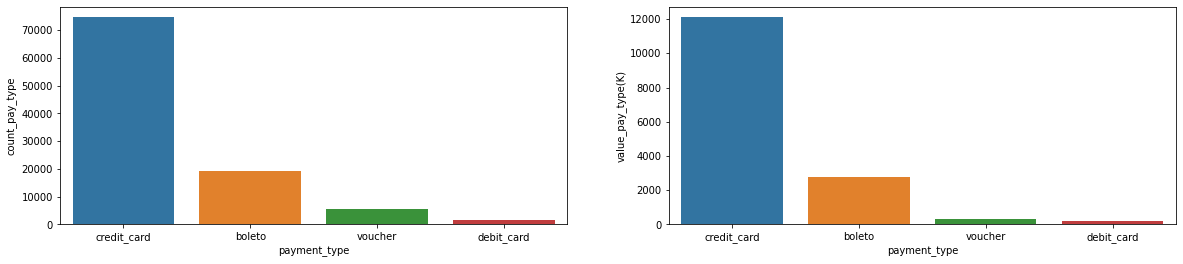

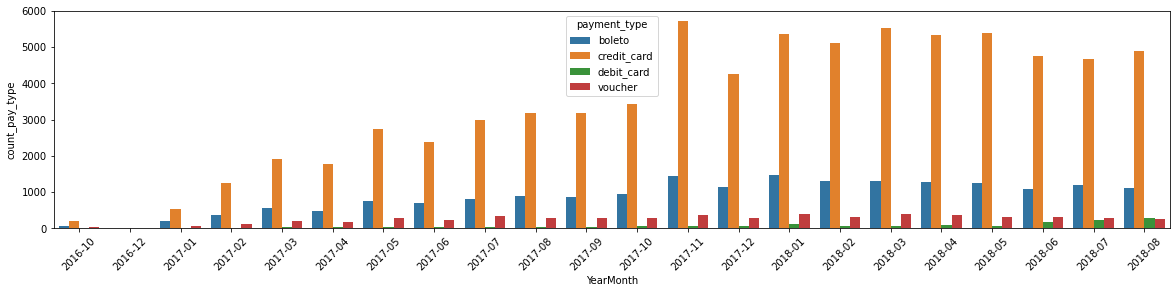

In [10]:
# combined_plot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))

sns.barplot(data=result_df_3, x='payment_type', y = 'count_pay_type', ax = ax1)
sns.barplot(data=result_df_3, x='payment_type', y = 'value_pay_type(K)', ax = ax2)
# ax1.bar_label(ax1.containers[0])
# ax2.bar_label(ax2.containers[0])

fig, ax3 = plt.subplots(nrows=1, ncols=1, figsize=(20, 4))
sns.barplot(data=result_df_3_1, x='YearMonth', y = 'count_pay_type', hue = 'payment_type', ax = ax3)
plt.xticks(rotation = 45)
# ax3.bar_label(ax3.containers[0])

plt.show()

### 4.Delivery Speed

Text(-8.825000000000003, 0.5, 'Count')

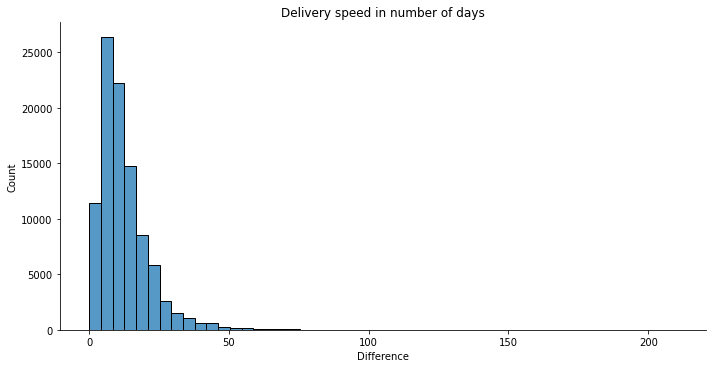

In [11]:
# SQL_Query_4
# Step 3: Write SQL query in a string variable
sql_query_4 = """
    SELECT strftime("%Y-%m-%d", order_delivered_customer_date) AS delivered_date, strftime("%Y-%m-%d", order_purchase_timestamp) AS purchased_date
    FROM orders_dataset
    WHERE order_status = 'delivered'
    """

# Step 4: Exectue the SQL query
result_df_4 = sql_query_to_pd(sql_query_4, db_name='capstone.db')
result_df_4['delivered_date'] = pd.to_datetime(result_df_4['delivered_date'])
result_df_4['purchased_date'] = pd.to_datetime(result_df_4['purchased_date'])
result_df_4['difference'] = (result_df_4['delivered_date'] - result_df_4['purchased_date']).dt.days

fig4 = sns.displot(result_df_4['difference'], bins=50, height=5, aspect=2)
plt.title('Delivery speed in number of days')
plt.xlabel('Difference')
plt.ylabel('Count')


In [12]:
result_df_4['difference'].describe([0.8,0.95,0.90,0.99])

count    96470.000000
mean        12.496849
std          9.555071
min          0.000000
50%         10.000000
80%         17.000000
90%         23.000000
95%         29.000000
99%         46.000000
max        210.000000
Name: difference, dtype: float64

## Trends Over Time

### 5.Sales Quantity Purchase by Month

In [13]:
# SQL_Query_5, order_purchase breakdown in year and month
sql_query_5 = """   SELECT Month as month_no, CASE WHEN a.Month = '01' THEN 'Jan'
                                                  WHEN a.Month = '02' THEN 'Feb'
                                                  WHEN a.Month = '03' THEN 'Mar'
                                                  WHEN a.Month = '04' THEN 'Apr'
                                                  WHEN a.Month = '05' THEN 'May'
                                                  WHEN a.Month = '06' THEN 'Jun'
                                                  WHEN a.Month = '07' THEN 'Jul'
                                                  WHEN a.Month = '08' THEN 'Aug'
                                                  WHEN a.Month = '09' THEN 'Sep'
                                                  WHEN a.Month = '10' THEN 'Oct'
                                                  WHEN a.Month = '11' THEN 'Nov'
                                                  WHEN a.Month = '12' THEN 'Dec'
                                                  ELSE 0 END AS Month,
                          SUM(CASE WHEN a.Year='2016' THEN 1 ELSE 0 END) AS year_2016,
                          SUM(CASE WHEN a.Year='2017' THEN 1 ELSE 0 END) AS year_2017,
                          SUM(CASE WHEN a.Year='2018' THEN 1 ELSE 0 END) AS year_2018
                    FROM (SELECT customer_id, order_id, order_status, order_purchase_timestamp, 
                                 strftime('%Y',order_purchase_timestamp) AS Year,
                                 strftime('%m',order_purchase_timestamp) AS Month
                          FROM orders_dataset
                          WHERE order_status <> 'unavailable' AND order_status <>'canceled'
                          GROUP BY customer_id, order_id
                          ORDER BY order_purchase_timestamp) AS a
                    GROUP BY Month
                    ORDER BY Month_no ASC; """

# Step 4: Exectue the SQL query
result_df_5 = sql_query_to_pd(sql_query_5, db_name="capstone.db")
result_df_5

,month_no,Month,year_2016,year_2017,year_2018
0,01,Jan,0,787,7187
1,02,Feb,0,1718,6625
2,03,Mar,0,2617,7168
3,04,Apr,0,2377,6919
4,05,May,0,3640,6833
5,06,Jun,0,3205,6145
6,07,Jul,0,3946,6233
7,08,Aug,0,4272,6421
8,09,Sep,2,4227,1
9,10,Oct,293,4547,0


In [14]:
# query "Year" for subsequent combined plot
query = """ SELECT  strftime('%Y', order_purchase_timestamp) AS Year,
                COUNT(DISTINCT order_id) AS Num_Purchase
            FROM  orders_dataset
            WHERE  order_status <> 'unavailable' AND  order_status <> 'canceled'
            GROUP BY Year
            ORDER BY Year; """

# Step 4: Exectue the SQL query
Year = sql_query_to_pd(query, db_name="capstone.db")
Year

,Year,Num_Purchase
0,2016,296
1,2017,44379
2,2018,53532


In [15]:
# query "Month" for subsequent combined plot
query = """ SELECT  STRFTIME('%m', order_purchase_timestamp) AS Month,
                COUNT(DISTINCT order_id) AS Num_Purchase
            FROM  orders_dataset
            WHERE  order_status <> 'unavailable' AND  order_status <> 'canceled'
            GROUP BY Month
            ORDER BY Month; """

# Step 4: Exectue the SQL query
Month = sql_query_to_pd(query, db_name="capstone.db")
Month 

,Month,Num_Purchase
0,01,7974
1,02,8343
2,03,9785
3,04,9296
4,05,10473
5,06,9350
6,07,10179
7,08,10693
8,09,4230
9,10,4840


In [16]:
# query "Yearmonth" for subsequent combined plot
query = """ SELECT  strftime('%Y-%m', order_purchase_timestamp) AS YearMonth,
                COUNT(DISTINCT order_id) AS Num_Purchase
            FROM  orders_dataset
            WHERE  order_status <> 'unavailable' AND  order_status <> 'canceled'
            GROUP BY  YearMonth
            ORDER BY  YearMonth;"""
# Step 4: Exectue the SQL query
YearMonth = sql_query_to_pd(query, db_name="capstone.db")
YearMonth

,YearMonth,Num_Purchase
0,2016-09,2
1,2016-10,293
2,2016-12,1
3,2017-01,787
4,2017-02,1718
5,2017-03,2617
6,2017-04,2377
7,2017-05,3640
8,2017-06,3205
9,2017-07,3946


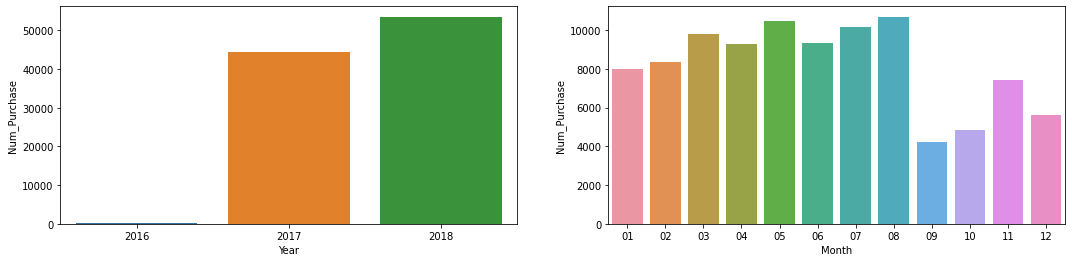

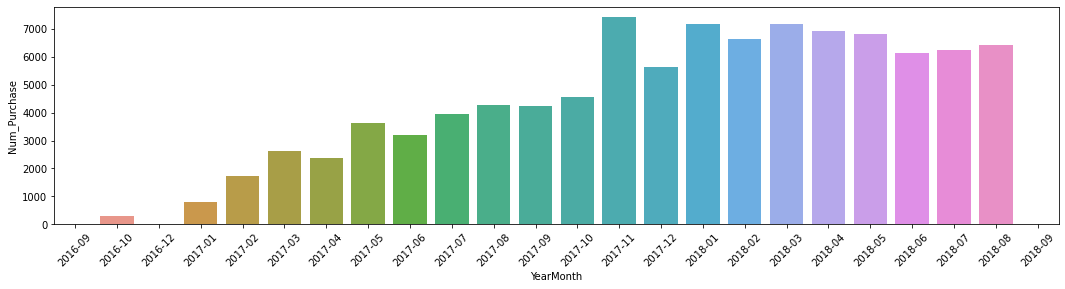

In [17]:
# combined_plot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))

sns.barplot(data = Year, x = 'Year', y = 'Num_Purchase', ax=ax1)
sns.barplot(data = Month, x = 'Month', y = 'Num_Purchase', ax=ax2)
# ax1.bar_label(ax1.containers[0])
# ax2.bar_label(ax2.containers[0])

fig, ax3 = plt.subplots(nrows=1, ncols=1, figsize=(18, 4))
sns.barplot(data = YearMonth, x = 'YearMonth', y = 'Num_Purchase', ax=ax3)
plt.xticks(rotation = 45)
# ax3.bar_label(ax3.containers[0])

plt.show()

### 6.Sales Quantity Approved by Month

In [18]:
# SQL_Query_6
# Step 3: Write the SQL query in a string variable
sql_query_6 = """
    SELECT strftime("%Y-%m", order_approved_at) AS date, count(order_id) AS order_qty
    FROM orders_dataset 
    GROUP BY date
    ORDER BY date 
    """
 
# Step 4: Exectue the SQL query
result_df_6 = sql_query_to_pd(sql_query_6, db_name='capstone.db')
result_df_6

,date,order_qty
0,None,160
1,2016-09,1
2,2016-10,320
3,2016-12,1
4,2017-01,760
5,2017-02,1765
6,2017-03,2689
7,2017-04,2374
8,2017-05,3693
9,2017-06,3252


In [19]:
fig6 = px.line(result_df_6, x="date", y="order_qty", title='Qty of Sales Order Approved by Time in Brazilian E-Commerce (2016-2018')
iplot(fig6)

### 7.Sales Value Approved by Month

In [20]:
# SQL_Query_7
# Step 3: Write the SQL query in a string variable
sql_query_7 = """
    SELECT strftime("%Y-%m", a.order_approved_at) AS date, sum(b.price) AS sales_value
    FROM orders_dataset AS a 
    LEFT JOIN order_items_dataset AS b 
    ON a.order_id = b.order_id
    GROUP BY date
    ORDER BY date 
    """
 
# Step 4: Exectue the SQL query
result_df_7 = sql_query_to_pd(sql_query_7, db_name='capstone.db')
result_df_7

,date,sales_value
0,None,1670.43
1,2016-09,134.97
2,2016-10,49640.05
3,2016-12,10.90
4,2017-01,114860.71
5,2017-02,247441.08
6,2017-03,370611.56
7,2017-04,357638.73
8,2017-05,507167.89
9,2017-06,437278.58


In [21]:
fig7 = px.line(result_df_7, x="date", y="sales_value", title='Value of Sales Order Approved by Month in Brazilian E-Commerce (2016-2018')
iplot(fig7)

In [22]:
# SQL_Query_7_1
# Step 3: Write the SQL query in a string variable
sql_query_7_1 = """
    SELECT strftime("%Y-%m-%d", a.order_approved_at) AS date, sum(b.price) AS sales_value
    FROM orders_dataset AS a 
    LEFT JOIN order_items_dataset AS b
    ON a.order_id = b.order_id
    GROUP BY date
    ORDER BY date
    """

# Step 4: Exectue the SQL query
result_df_7_1 = sql_query_to_pd(sql_query_7_1, db_name="capstone.db")
result_df_7_1

,date,sales_value
0,None,1670.43
1,2016-09-15,134.97
2,2016-10-04,2443.57
3,2016-10-05,1622.05
4,2016-10-06,17515.56
...,...,...
607,2018-08-26,10219.14
608,2018-08-27,5726.50
609,2018-08-28,5106.30
610,2018-08-29,1987.63


In [23]:
fig7_1 = px.line(result_df_7_1, x="date", y="sales_value", title='Value of Sales Order Approved by Date in Brazilian E-Commerce (2016-2018')
iplot(fig7_1)

### 8.Sales Price by Category by Month

In [24]:
# SQL_Query_8
# Step 3: Write the SQL query in a string variable
sql_query_8 = """
    SELECT strftime("%Y-%m", d.order_approved_at) AS date, count(b.product_category_name) AS qty, 
           c.product_category_name_english AS product, sum(a.price) AS sales_value 
    FROM order_items_dataset AS a
    LEFT JOIN products_dataset AS b
    ON a.product_id = b.product_id
    INNER JOIN product_category_name_translation AS c
    ON b.product_category_name = c.product_category_name
    INNER JOIN orders_dataset AS d 
    ON a.order_id = d.order_id
    GROUP BY date, product
    ORDER BY date, sales_value DESC 
    """
 
# Step 4: Exectue the SQL query
result_df_8 = sql_query_to_pd(sql_query_8, db_name='capstone.db')
result_df_8

,date,qty,product,sales_value
0,None,1,construction_tools_safety,379.00
1,None,1,small_appliances,309.90
2,None,3,furniture_decor,255.60
3,None,3,cool_stuff,239.97
4,None,1,garden_tools,135.00
...,...,...,...,...
1251,2018-08,2,fashion_underwear_beach,219.90
1252,2018-08,3,fashio_female_clothing,129.97
1253,2018-08,1,fashion_sport,69.90
1254,2018-08,1,dvds_blu_ray,8.90


### 9.Trend of order_review of score_5 
- by month on 2018
- review_score is 5 
- where status is 'delivered' and    

In [25]:
# SQL_Query_9 orders, order_reviews
sql_query_9 = """ SELECT yearmonth, score_5, count_id, 
                          ROUND(CAST(score_5 AS float)/ CAST(count_id AS float)*100, 2) AS percentage
                   FROM (
                     SELECT strftime('%Y-%m', a.review_answer_timestamp) AS yearmonth, 
                            SUM(CASE WHEN a.review_score=5 THEN 1 ELSE 0 END) AS score_5,
                            COUNT(DISTINCT a.order_id) AS count_id
                     FROM order_reviews_dataset AS a
                     LEFT JOIN orders_dataset AS b
                     ON a.order_id = b.order_id
                     WHERE b.order_status = 'delivered' AND strftime('%Y', a.review_answer_timestamp) = '2018'
                     GROUP BY yearmonth 
                   ) """

# Step 4: Exectue the SQL query
result_df_9 = sql_query_to_pd(sql_query_9, db_name='capstone.db')
result_df_9

,yearmonth,score_5,count_id,percentage
0,2018-01,3539,6120,57.83
1,2018-02,3378,5882,57.43
2,2018-03,3750,7355,50.99
3,2018-04,4023,7421,54.21
4,2018-05,4551,7366,61.78
5,2018-06,3835,6264,61.22
6,2018-07,3743,5737,65.24
7,2018-08,5441,8544,63.68
8,2018-09,401,620,64.68
9,2018-10,22,31,70.97


<function matplotlib.pyplot.show(*args, **kw)>

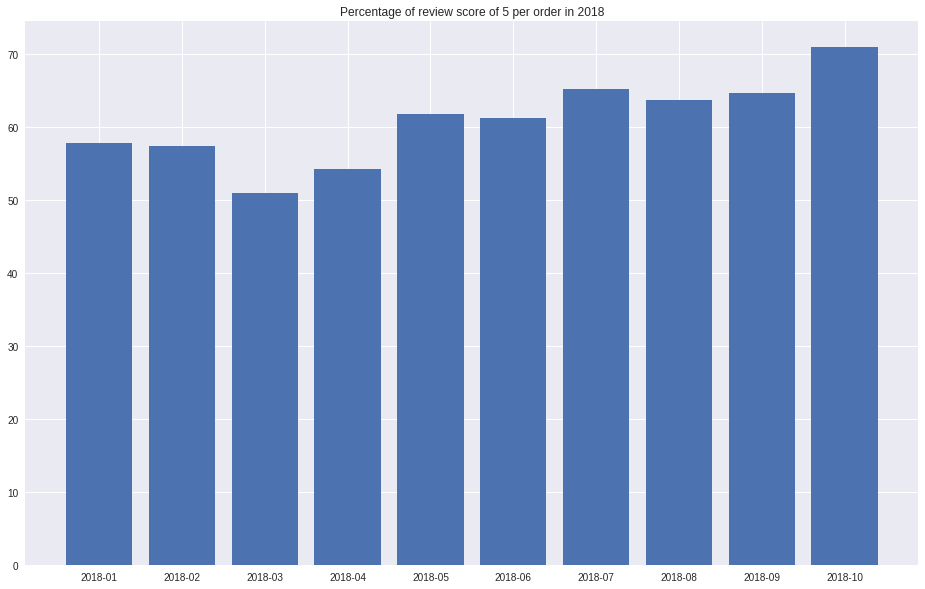

In [26]:
# plot customers per state
plt.style.use('seaborn')
plt.figure(figsize=(16,10))
plt.bar(result_df_9['yearmonth'], result_df_9['percentage'])
plt.title('Percentage of review score of 5 per order in 2018')
plt.show

## By Product Category

### 10.Product Sales by Category 

In [27]:
# SQL_Query_10
# Step 3: Write the SQL query in a string variable
sql_query_10 = """
    SELECT product_category_name_english AS product, count(b.product_category_name) AS qty 
    FROM product_category_name_translation AS a
    LEFT JOIN products_dataset AS b
    ON a.product_category_name = b.product_category_name  
    GROUP BY product
    ORDER BY qty DESC 
    """
 
# Step 4: Exectue the SQL query
result_df_10 = sql_query_to_pd(sql_query_10, db_name='capstone.db')
result_df_10

,product,qty
0,bed_bath_table,3029
1,sports_leisure,2867
2,furniture_decor,2657
3,health_beauty,2444
4,housewares,2335
...,...,...
66,tablets_printing_image,9
67,fashion_childrens_clothes,5
68,home_comfort_2,5
69,security_and_services,2


In [28]:
# plotting selling product categories quantity data
fig10 = px.bar(result_df_10.head(20), x="qty", y="product", orientation='h', barmode="group",title='Top 20 Selling Product Categories in Brazilian E-Commerce (2016-2018)')
fig10.update_layout(yaxis={'categoryorder':'total ascending'})
iplot(fig10)

### 11.Sales Price by Category

In [29]:
# SQL_Query_11
# Step 3: Write the SQL query in a string variable
sql_query_11 = """
    SELECT sum(a.price) AS sales_value, c.product_category_name_english AS product 
    FROM order_items_dataset AS a
    LEFT JOIN products_dataset AS b
    ON a.product_id = b.product_id
    INNER JOIN product_category_name_translation AS c
    ON b.product_category_name = c.product_category_name
    GROUP BY product
    ORDER BY sales_value DESC 
    """
 
# Step 4: Exectue the SQL query
result_df_11 = sql_query_to_pd(sql_query_11, db_name='capstone.db')
result_df_11

,sales_value,product
0,1258681.34,health_beauty
1,1205005.68,watches_gifts
2,1036988.68,bed_bath_table
3,988048.97,sports_leisure
4,911954.32,computers_accessories
...,...,...
66,1110.04,flowers
67,760.27,home_comfort_2
68,730.00,cds_dvds_musicals
69,569.85,fashion_childrens_clothes


### 12.Average Price by Category 

In [30]:
# SQL_Query_12
# Step 3: Write the SQL query in a string variable
sql_query_12 = """
    SELECT avg(a.price) AS avg_price, c.product_category_name_english AS product 
    FROM order_items_dataset AS a
    LEFT JOIN products_dataset AS b
    ON a.product_id = b.product_id
    INNER JOIN product_category_name_translation AS c
    ON b.product_category_name = c.product_category_name
    GROUP BY product 
    """
 
# Step 4: Exectue the SQL query
result_df_12 = sql_query_to_pd(sql_query_12, db_name='capstone.db')
result_df_12

,avg_price,product
0,342.124858,agro_industry_and_commerce
1,185.269226,air_conditioning
2,115.802105,art
3,75.583750,arts_and_craftmanship
4,139.254121,audio
...,...,...
66,91.753369,stationery
67,90.703735,tablets_printing_image
68,71.213978,telephony
69,117.548360,toys


### 13.Average Score by Category

In [31]:
# SQL_Query_13
# Step 3: Write the SQL query in a string variable
sql_query_13="""
    SELECT AVG(a.review_score) as avg_review_score, d.product_category_name_english AS product
    FROM order_reviews_dataset AS a
    LEFT JOIN order_items_dataset AS b
    ON a.order_id = b.order_id
    INNER JOIN products_dataset AS c
    ON b.product_id = c.product_id
    INNER JOIN product_category_name_translation AS d
    ON c.product_category_name = d.product_category_name
    GROUP BY product
    """

# Step 4: Exectue the SQL query
result_df_13 = sql_query_to_pd(sql_query_13, db_name='capstone.db')
result_df_13

,avg_review_score,product
0,4.000000,agro_industry_and_commerce
1,3.969178,air_conditioning
2,3.937198,art
3,4.125000,arts_and_craftmanship
4,3.825485,audio
...,...,...
66,4.193857,stationery
67,4.123457,tablets_printing_image
68,3.946867,telephony
69,4.158641,toys


In [32]:
# plot selling product categories quantity data
fig13 = px.bar(result_df_13, x="avg_review_score", y="product", orientation='h', barmode="group", title='Avg Review Score by Categories')
fig13.update_layout(yaxis={'categoryorder':'total ascending'})
iplot(fig13)

## Joining Tables of Delivered Orders

### 14.Joining all delivered orders

In [33]:
# SQL_Query_14
# Step 3: Write the SQL query in a string variable
sql_query_14 = """
    SELECT a.customer_id, strftime("%Y-%m-%d", b.order_approved_at) AS date, 
    b.order_id, c.order_item_id, c.price, d.review_score, f.product_category_name_english,
    g.payment_value
    FROM customers_dataset AS a
    LEFT JOIN orders_dataset AS b
    ON a.customer_id = b.customer_id 
    LEFT JOIN order_items_dataset AS c
    ON b.order_id = c.order_id 
    LEFT JOIN order_reviews_dataset AS d
    ON c.order_id = d.order_id
    LEFT JOIN products_dataset AS e
    ON c.product_id = e.product_id
    INNER JOIN product_category_name_translation AS f
    ON e.product_category_name = f.product_category_name 
    INNER JOIN order_payments_dataset AS g
    ON b.order_id = g.order_id
    WHERE b.order_status = 'delivered'
    """

# Step 4: Exectue the SQL query and save to csv
result_df_14 = sql_query_to_pd(sql_query_14, db_name="capstone.db")
result_df_14.to_csv('./datasets/joined_tables.csv',index=False)
result_df_14

,customer_id,date,order_id,order_item_id,price,review_score,product_category_name_english,payment_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16,00e7ee1b050b8499577073aeb2a297a1,1,124.99,4.0,office_furniture,146.87
1,18955e83d337fd6b2def6b18a428ac77,2018-01-12,29150127e6685892b6eab3eec79f59c7,1,289.00,5.0,housewares,335.48
2,4e7b3e00288586ebd08712fdd0374a03,2018-05-20,b2059ed67ce144a36e2aa97d2c9e9ad2,1,139.94,5.0,office_furniture,157.73
3,b2b6027bc5c5109e529d4dc6358b12c3,2018-03-13,951670f92359f4fe4a63112aa7306eba,1,149.94,5.0,office_furniture,173.30
4,4f2d8ab171c80ec8364f7c12e35b23ad,2018-07-29,6b7d50bd145f6fc7f33cebabd7e49d0f,1,230.00,5.0,home_confort,252.25
...,...,...,...,...,...,...,...,...
114054,17ddf5dd5d51696bb3d7c6291687be6f,2018-04-07,6760e20addcf0121e9d58f2f1ff14298,1,74.90,4.0,books_general_interest,88.78
114055,e7b71a9017aa05c9a7fd292d714858e8,2018-04-04,9ec0c8947d973db4f4e8dcf1fbfa8f1b,1,114.90,5.0,sports_leisure,129.06
114056,5e28dfe12db7fb50a4b2f691faecea5e,2018-04-08,fed4434add09a6f332ea398efd656a5c,1,37.00,1.0,health_beauty,56.04
114057,56b18e2166679b8a959d72dd06da27f9,2017-11-03,e31ec91cea1ecf97797787471f98a8c2,1,689.00,5.0,watches_gifts,711.07


## SQLAlchemy

In [34]:
from sqlalchemy import create_engine

In [35]:
# generating engine to make it possible to connect the query into the defined database
engine = create_engine("sqlite://", echo=False)

In [36]:
# export dataframes to database
customers_df.to_sql(name = 'customers', con=engine)
orders_df.to_sql(name='orders', con=engine)
order_items_df.to_sql(name='order_items', con=engine)
products_df.to_sql(name='products', con=engine)
product_category_name_translation.to_sql(name='product_category_name_translated', con=engine)
geolocation_df.to_sql(name='geolocation',con=engine)
order_payments_df.to_sql(name='order_payments', con=engine)
order_reviews_df.to_sql(name='order_reviews', con=engine)
sellers_df.to_sql(name='sellers', con=engine)

In [37]:
sql_query_15 = "SELECT * FROM sqlite_master"
db = pd.read_sql_query(sql=sql_query_15, con=engine)
db[db['type'] == 'table']

,type,name,tbl_name,rootpage,sql
0,table,customers,customers,2,"CREATE TABLE customers (\n\t""index"" BIGINT, \n..."
2,table,orders,orders,2644,"CREATE TABLE orders (\n\t""index"" BIGINT, \n\to..."
4,table,order_items,order_items,7660,"CREATE TABLE order_items (\n\t""index"" BIGINT, ..."
6,table,products,products,12195,"CREATE TABLE products (\n\t""index"" BIGINT, \n\..."
8,table,product_category_name_translated,product_category_name_translated,12889,CREATE TABLE product_category_name_translated ...
10,table,geolocation,geolocation,12891,"CREATE TABLE geolocation (\n\t""index"" BIGINT, ..."
12,table,order_payments,order_payments,27817,"CREATE TABLE order_payments (\n\t""index"" BIGIN..."
14,table,order_reviews,order_reviews,29836,"CREATE TABLE order_reviews (\n\t""index"" BIGINT..."
16,table,sellers,sellers,33911,"CREATE TABLE sellers (\n\t""index"" BIGINT, \n\t..."


In [38]:
# get to know what type of each column of table
for i in db[db['type'] == 'table']['sql']:
  print(i)

CREATE TABLE customers (
	"index" BIGINT, 
	customer_id TEXT, 
	customer_unique_id TEXT, 
	customer_zip_code_prefix BIGINT, 
	customer_city TEXT, 
	customer_state TEXT
)
CREATE TABLE orders (
	"index" BIGINT, 
	order_id TEXT, 
	customer_id TEXT, 
	order_status TEXT, 
	order_purchase_timestamp TEXT, 
	order_approved_at TEXT, 
	order_delivered_carrier_date TEXT, 
	order_delivered_customer_date TEXT, 
	order_estimated_delivery_date TEXT
)
CREATE TABLE order_items (
	"index" BIGINT, 
	order_id TEXT, 
	order_item_id BIGINT, 
	product_id TEXT, 
	seller_id TEXT, 
	shipping_limit_date TEXT, 
	price FLOAT, 
	freight_value FLOAT
)
CREATE TABLE products (
	"index" BIGINT, 
	product_id TEXT, 
	product_category_name TEXT, 
	product_name_lenght FLOAT, 
	product_description_lenght FLOAT, 
	product_photos_qty FLOAT, 
	product_weight_g FLOAT, 
	product_length_cm FLOAT, 
	product_height_cm FLOAT, 
	product_width_cm FLOAT
)
CREATE TABLE product_category_name_translated (
	"index" BIGINT, 
	product_catego

### 15.Top 10 and Bottom 10 Selling Product Categories 

In [39]:
query1 = """SELECT p.product_category_name_english AS category,
               COUNT(DISTINCT p.order_id) AS num_order,
               SUM(p.payment_value) AS revenue
            FROM   (
              SELECT *
              FROM  products AS a
              LEFT JOIN  product_category_name_translated AS b
              ON  a.product_category_name = b.product_category_name
              LEFT JOIN  order_items AS c
              ON  a.product_id = c.product_id
              LEFT JOIN  orders AS d
              ON  c.order_id = d.order_id
              LEFT JOIN  order_payments AS e
              ON  c.order_id = e.order_id ) AS p
            WHERE category IS NOT NULL AND p.order_status <> 'canceled' AND p.order_delivered_customer_date IS NOT NULL
        GROUP BY category
        ORDER BY revenue DESC
        LIMIT  10
        """

query2 = """SELECT p.product_category_name_english AS category,
               COUNT(DISTINCT p.order_id) AS num_order,
               SUM(p.payment_value) AS revenue
            FROM   (
              SELECT *
              FROM  products AS a
              LEFT JOIN  product_category_name_translated AS b
              ON  a.product_category_name = b.product_category_name
              LEFT JOIN  order_items AS c
              ON  a.product_id = c.product_id
              LEFT JOIN  orders AS d
              ON  c.order_id = d.order_id
              LEFT JOIN  order_payments AS e
              ON  c.order_id = e.order_id ) AS p
            WHERE category IS NOT NULL AND p.order_status <> 'canceled' AND p.order_delivered_customer_date IS NOT NULL
        GROUP BY category
        ORDER BY revenue ASC
        LIMIT  10
        """

df_query_15_top10 = pd.read_sql_query(query1, engine)
df_query_15_bot10 = pd.read_sql_query(query2, engine)
display(df_query_15_top10, df_query_15_bot10)

,category,num_order,revenue
0,bed_bath_table,9272,1692714.28
1,health_beauty,8647,1620684.04
2,computers_accessories,6529,1549252.47
3,furniture_decor,6307,1394466.93
4,watches_gifts,5493,1387046.31
5,sports_leisure,7529,1349252.93
6,housewares,5743,1069787.97
7,auto,3809,833610.84
8,garden_tools,3448,810614.93
9,cool_stuff,3559,744649.32


,category,num_order,revenue
0,security_and_services,2,324.51
1,fashion_childrens_clothes,7,718.98
2,cds_dvds_musicals,12,1199.43
3,home_comfort_2,24,1710.54
4,flowers,29,2213.01
5,arts_and_craftmanship,23,2326.17
6,la_cuisine,13,2913.53
7,fashion_sport,26,3605.83
8,diapers_and_hygiene,25,4126.17
9,fashio_female_clothing,36,4902.67


In [40]:
query_15_1 = """SELECT strftime('%Y-%m', d.order_purchase_timestamp) AS YearMonth, b.product_category_name_english AS category, COUNT(DISTINCT d.order_id) AS num_order,SUM(e.payment_value) AS revenue
                FROM products AS a
                LEFT JOIN product_category_name_translated AS b
                ON  a.product_category_name = b.product_category_name
                LEFT JOIN order_items AS c
                ON  a.product_id = c.product_id
                LEFT JOIN orders AS d
                ON  c.order_id = d.order_id
                LEFT JOIN order_payments AS e
                ON  c.order_id = e.order_id
                GROUP BY YearMonth, category
                ORDER BY YearMonth ;"""
df_query_15_1 = pd.read_sql_query(query_15_1, engine)
df_query_15_1                

,YearMonth,category,num_order,revenue
0,2016-09,furniture_decor,1,272.46
1,2016-09,health_beauty,1,NaN
2,2016-09,telephony,1,75.06
3,2016-10,None,2,95.92
4,2016-10,air_conditioning,5,4675.43
...,...,...,...,...
1269,2018-08,stationery,159,20666.86
1270,2018-08,telephony,246,68240.47
1271,2018-08,toys,155,27884.78
1272,2018-08,watches_gifts,392,85215.66


### 16.Top Sellers
- group by category and seller_id
- top 5 sellers for each category

In [41]:
sql_query_16 = """SELECT s.product_category_name_english AS category, s.seller_id, SUM(s.payment_value) AS revenue
                  FROM( SELECT *
                        FROM sellers AS a
                        LEFT JOIN order_items AS b
                        ON a.seller_id = b.seller_id
                        LEFT JOIN products AS c
                        ON b.product_id = c.product_id
                        LEFT JOIN product_category_name_translated AS d
                        ON c.product_category_name = d.product_category_name
                        LEFT JOIN order_payments AS e 
                        ON b.order_id = e.order_id 
                        LEFT JOIN orders AS f
                        ON b.order_id = f.order_id) AS s
                  WHERE category IS NOT NULL AND s.order_status <> 'canceled' AND s.order_delivered_customer_date IS NOT NULL
                  GROUP BY category, seller_id
                  ORDER BY category, revenue DESC; """

df_query_16 = pd.read_sql_query(sql_query_16, engine)
print(df_query_16['seller_id'].nunique())
df_query_16

2912


,category,seller_id,revenue
0,agro_industry_and_commerce,e59aa562b9f8076dd550fcddf0e73491,38875.08
1,agro_industry_and_commerce,f08a5b9dd6767129688d001acafc21e5,38203.91
2,agro_industry_and_commerce,6bd69102ab48df500790a8cecfc285c2,8359.02
3,agro_industry_and_commerce,2528744c5ef5d955adc318720a94d2e7,6508.70
4,agro_industry_and_commerce,31ae0774c17fabd06ff707cc5bde005f,5690.23
...,...,...,...
6139,watches_gifts,89f69225956f951295ca4c7fb1266553,71.37
6140,watches_gifts,2ff97219cb8622eaf3cd89b7d9c09824,56.22
6141,watches_gifts,891071be6ba827b591264c90c2ae8a63,35.96
6142,watches_gifts,1da3aeb70d7989d1e6d9b0e887f97c23,27.22


In [42]:
# group by category and sort by revenue
grouped = df_query_16.groupby(['category'])
top5_per_cat = grouped.apply(lambda x:x.sort_values(by = 'revenue', ascending = False)[:5])[['seller_id', 'revenue']]
top5_per_cat

seller_id    revenue
category                                                                    
agro_industry_and_commerce 0     e59aa562b9f8076dd550fcddf0e73491   38875.08
                           1     f08a5b9dd6767129688d001acafc21e5   38203.91
                           2     6bd69102ab48df500790a8cecfc285c2    8359.02
                           3     2528744c5ef5d955adc318720a94d2e7    6508.70
                           4     31ae0774c17fabd06ff707cc5bde005f    5690.23
...                                                           ...        ...
watches_gifts              6049  4869f7a5dfa277a7dca6462dcf3b52b2  229443.69
                           6050  fa1c13f2614d7b5c4749cbc52fecda94  200846.38
                           6051  7e93a43ef30c4f03f38b393420bc753a  167307.44
                           6052  6560211a19b47992c3666cc44a7e94c0  145412.45
                           6053  7d13fca15225358621be4086e1eb0964  101390.92

[340 rows x 2 columns]

In [43]:
# correct the multi index into single index to make data easier to be handled
top5_per_cat = top5_per_cat.droplevel(axis = 0, level = 1).reset_index()
top5_per_cat

,category,seller_id,revenue
0,agro_industry_and_commerce,e59aa562b9f8076dd550fcddf0e73491,38875.08
1,agro_industry_and_commerce,f08a5b9dd6767129688d001acafc21e5,38203.91
2,agro_industry_and_commerce,6bd69102ab48df500790a8cecfc285c2,8359.02
3,agro_industry_and_commerce,2528744c5ef5d955adc318720a94d2e7,6508.70
4,agro_industry_and_commerce,31ae0774c17fabd06ff707cc5bde005f,5690.23
...,...,...,...
335,watches_gifts,4869f7a5dfa277a7dca6462dcf3b52b2,229443.69
336,watches_gifts,fa1c13f2614d7b5c4749cbc52fecda94,200846.38
337,watches_gifts,7e93a43ef30c4f03f38b393420bc753a,167307.44
338,watches_gifts,6560211a19b47992c3666cc44a7e94c0,145412.45


### 17.Aggregation by 'state'
- aggregate of revenue by state
- top 5 product categories by 'state'


In [44]:
sql_query_17 = """SELECT  s.customer_state, sum(s.payment_value) AS revenue
                  FROM    (
                        SELECT a.customer_id, a.customer_state, c.payment_value
                        FROM customers AS a
                        LEFT JOIN orders AS b
                        ON   a.customer_id = b.customer_id
                        LEFT JOIN order_payments AS c
                        ON   b.order_id = c.order_id
                        WHERE order_status <> 'canceled' AND order_delivered_customer_date IS NOT NULL
                        ) AS s
                  GROUP BY     customer_state
                  ORDER BY     revenue Desc
                  """

df_query_17 = pd.read_sql_query(sql_query_17, engine)
df_query_17

,customer_state,revenue
0,SP,5769081.27
1,RJ,2055690.45
2,MG,1819277.61
3,RS,861608.40
4,PR,781919.55
5,SC,595208.40
6,BA,591270.60
7,DF,346146.17
8,GO,334294.22
9,ES,317682.65


In [45]:
sql_query_17_1 = """ SELECT s.customer_state, s.product_category_name_english AS category, SUM(s.payment_value) AS revenue
                   FROM (
                     SELECT a.customer_id, customer_state, payment_value, product_category_name_english
                     FROM customers AS a
                     LEFT JOIN orders AS b
                     ON   a.customer_id = b.customer_id
                     LEFT JOIN order_payments AS c
                     ON   b.order_id = c.order_id
                     LEFT JOIN order_items AS d
                     ON   b.order_id = d.order_id
                     LEFT JOIN products AS e
                     ON   d.product_id = e.product_id
                     LEFT JOIN product_category_name_translated AS f
                     ON   e.product_category_name = f.product_category_name
                     WHERE order_status <> 'canceled' AND order_delivered_customer_date IS NOT NULL AND product_category_name_english IS NOT NULL) AS s
                   GROUP BY customer_state, category
                   ORDER BY revenue DESC; """

df_query_17_1 = pd.read_sql_query(sql_query_17_1, engine)
df_query_17_1


,customer_state,category,revenue
0,SP,bed_bath_table,756727.97
1,SP,computers_accessories,622212.26
2,SP,health_beauty,604558.90
3,SP,furniture_decor,533872.18
4,SP,sports_leisure,509044.62
...,...,...,...
1346,BA,home_comfort_2,29.69
1347,GO,dvds_blu_ray,28.01
1348,ES,home_comfort_2,28.00
1349,PR,home_comfort_2,28.00


In [46]:
grouped = df_query_17_1.groupby('customer_state')
top_5_cat = grouped.apply(lambda g:g.sort_values(by = 'revenue', ascending = False)[:5])[['category', 'revenue']]
top_5_cat = top_5_cat.droplevel(axis = 0, level = 1).reset_index()
top_5_cat.head()

,customer_state,category,revenue
0,AC,furniture_decor,5261.23
1,AC,sports_leisure,2071.54
2,AC,health_beauty,2067.62
3,AC,computers_accessories,1765.24
4,AC,watches_gifts,1573.72


### 18.Date Difference by 'state'

In [47]:
sql_query_18 = """ SELECT customer_state AS state, CAST(AVG(JULIANDAY(date_est_del) - JULIANDAY(date_approved)) AS int) AS datediff
                   FROM (
                     SELECT order_id, customer_id, strftime('%Y-%m-%d', order_approved_at) AS date_approved, strftime('%Y-%m-%d', order_estimated_delivery_date) AS date_est_del
                     FROM   orders
                     WHERE  order_status <> 'canceled' AND order_approved_at IS NOT NULL 
                     ) AS a
                   LEFT JOIN (
                     SELECT customer_id, customer_state
                     FROM   customers

                     ) AS b
                   ON a.customer_id = b.customer_id
                   GROUP BY state
                   ORDER BY datediff ASC;"""

df_query_18 = pd.read_sql_query(sql_query_18, engine)
df_query_18

,state,datediff
0,SP,19
1,DF,24
2,MG,24
3,PR,24
4,ES,25
5,SC,25
6,MS,26
7,RJ,26
8,GO,27
9,RS,28


### 19.Repurchase rate for top 3 product categories
- using customers' purchase rate to create a datamart 
- purpose: to understand customer purchase behaviour, to analyze the key business KPIs and find insights
- The categories to be checked in this project are as follows:
  - bed_bath_table
  - health_beauty
  - computer_accessories
- For all 3 categories, the variables to be creadted as follows:
  - date of first purchase
  - date of last purchase
  - number of orders per customer
  - repurchase or not
  - repurchase_interval
  - cycle purchase = repurchase_interval/(number of orders - 1)

Together with RFM analysis, K-Means clustering 
(unsupervised machine learning method) was used to classify the customers.

Data mart is usually designed and built specifically for a particular department and business function.

The detail is below, [reference](https://www.holistics.io/blog/data-lake-vs-data-warehouse-vs-data-mart/) 

In [48]:
# The top selling category == bed_bath_table

query = """ SELECT  *,
                CASE WHEN first_pur < recent_pur THEN 'Y' ELSE 'N' END AS repurchase,
                CAST(JULIANDAY(recent_pur) - JULIANDAY(first_pur) AS int) AS interval_pur,
                CASE WHEN count_order - 1 = 0 OR JULIANDAY(recent_pur) - JULIANDAY(first_pur) = 0 THEN 0
                     ELSE CAST((JULIANDAY(recent_pur) - JULIANDAY(first_pur)) / (count_order-1) AS int) END AS cycle_pur
            FROM    (
                SELECT  customer_unique_id,
                        MIN(STRFTIME('%Y-%m-%d',order_purchase_timestamp)) AS first_pur,
                        MAX(STRFTIME('%Y-%m-%d',order_purchase_timestamp)) AS recent_pur,
                        COUNT(DISTINCT A.order_id) AS count_order,
                        cat_name
                FROM    (
                        SELECT  customer_unique_id, a.order_id, order_purchase_timestamp, c.product_id
                        FROM    orders AS a
                        LEFT JOIN    customers AS b
                        ON      a.customer_id = b.customer_id
                        LEFT JOIN    order_items AS c
                        ON      a.order_id = c.order_id
                        WHERE   order_status <> 'canceled'
                        ) as A
                LEFT JOIN   (
                        SELECT product_id, product_category_name_english AS cat_name
                        FROM   products AS d
                        LEFT JOIN   product_category_name_translated AS e
                        ON     d.product_category_name = e.product_category_name
                        ) AS f
                ON      A.product_id = f.product_id
            WHERE   cat_name = 'bed_bath_table'
            GROUP BY      customer_unique_id );
        """

repur_bed_bath_tab = pd.read_sql_query(query, engine)
repur_bed_bath_tab

,customer_unique_id,first_pur,recent_pur,count_order,cat_name,repurchase,interval_pur,cycle_pur
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10,2018-05-10,1,bed_bath_table,N,0,0
1,0006fdc98a402fceb4eb0ee528f6a8d4,2017-07-18,2017-07-18,1,bed_bath_table,N,0,0
2,00090324bbad0e9342388303bb71ba0a,2018-03-24,2018-03-24,1,bed_bath_table,N,0,0
3,000c8bdb58a29e7115cfc257230fb21b,2017-12-12,2017-12-12,1,bed_bath_table,N,0,0
4,000de6019bb59f34c099a907c151d855,2017-08-17,2017-08-17,1,bed_bath_table,N,0,0
...,...,...,...,...,...,...,...,...
9122,ffd973d43cadfa3e60340bcad8d87696,2017-11-26,2017-11-26,1,bed_bath_table,N,0,0
9123,ffe254cc039740e17dd15a5305035928,2017-04-02,2017-04-02,2,bed_bath_table,N,0,0
9124,ffe2dd1f3b0cbf0b5f35e818ec03c49b,2017-03-05,2017-03-05,1,bed_bath_table,N,0,0
9125,ffe39c116d96cd81dcdfd9dcca655cd1,2017-07-24,2017-07-24,1,bed_bath_table,N,0,0


In [49]:
# the customer_unique_id who repurchased on Olist
repur_bed_bath_tab.loc[(repur_bed_bath_tab.repurchase == 'Y') & (repur_bed_bath_tab.count_order >= 2)]

,customer_unique_id,first_pur,recent_pur,count_order,cat_name,repurchase,interval_pur,cycle_pur
55,0178b244a5c281fb2ade54038dd4b161,2017-05-10,2018-07-28,2,bed_bath_table,Y,444,444
92,02e9109b7e0a985108b43e573b6afb23,2018-05-13,2018-05-14,2,bed_bath_table,Y,1,1
106,0333b2fc6ba7014702e08ef613850270,2017-08-24,2017-11-06,2,bed_bath_table,Y,74,74
138,043aee247e71edff7045664609f4d806,2017-03-22,2017-07-17,2,bed_bath_table,Y,117,117
146,048dbdf8f9bbd1be87b25868d1408311,2017-10-17,2017-11-06,2,bed_bath_table,Y,20,20
...,...,...,...,...,...,...,...,...
8887,f8f6ed51ded0d4757a6153f5ce0f8906,2018-04-16,2018-04-25,2,bed_bath_table,Y,9,9
8966,fb4accbcbcd54672a8a8b195d9ff0ec8,2017-07-24,2017-08-16,2,bed_bath_table,Y,23,23
8977,fb920961e4d8e55fd9c357976a611765,2017-03-25,2018-06-24,2,bed_bath_table,Y,456,456
9045,fd8ccc89be43894d2553494c71a61fd8,2018-03-13,2018-04-19,2,bed_bath_table,Y,37,37


In [50]:
# Ratio of customers who repurchase

print("***Ratio of repurchase - bed_bath_table***")
round(repur_bed_bath_tab['repurchase'].value_counts(normalize=True)*100, 2)

***Ratio of repurchase - bed_bath_table***


N    98.5
Y     1.5
Name: repurchase, dtype: float64

In [51]:
# health_beauty == beleza_saude in Portuguese
# generating data mart

query = """ SELECT  *,
                CASE WHEN first_pur < recent_pur THEN 'Y' ELSE 'N' END AS repurchase,
                CAST(JULIANDAY(recent_pur) - JULIANDAY(first_pur) AS int) AS interval_pur,
                CASE WHEN count_order - 1 = 0 OR JULIANDAY(recent_pur) - JULIANDAY(first_pur) = 0 THEN 0
                     ELSE CAST((JULIANDAY(recent_pur) - JULIANDAY(first_pur)) / (count_order-1) AS int) END AS cycle_pur
            FROM    (
                SELECT  customer_unique_id,
                        MIN(STRFTIME('%Y-%m-%d',order_purchase_timestamp)) AS first_pur,
                        MAX(STRFTIME('%Y-%m-%d',order_purchase_timestamp)) AS recent_pur,
                        COUNT(DISTINCT A.order_id) AS count_order,
                        cat_name
                FROM    (
                        SELECT  customer_unique_id, a.order_id, order_purchase_timestamp, c.product_id
                        FROM    orders AS a
                        LEFT JOIN    customers AS b
                        ON      a.customer_id = b.customer_id
                        LEFT JOIN    order_items AS c
                        ON      a.order_id = c.order_id
                        WHERE   order_status <> 'canceled'
                        ) AS A
                LEFT JOIN   (
                        SELECT product_id, product_category_name_english AS cat_name
                        FROM   products AS d
                        LEFT JOIN   product_category_name_translated AS e
                        ON     d.product_category_name = e.product_category_name
                        ) AS f
                ON      A.product_id = f.product_id
                WHERE   cat_name = 'health_beauty'
                GROUP BY      customer_unique_id );"""

repur_hb = pd.read_sql_query(query, engine)
repur_hb

,customer_unique_id,first_pur,recent_pur,count_order,cat_name,repurchase,interval_pur,cycle_pur
0,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07,2018-05-07,1,health_beauty,N,0,0
1,000a5ad9c4601d2bbdd9ed765d5213b3,2017-08-11,2017-08-11,1,health_beauty,N,0,0
2,0014a5a58da615f7b01a4f5e194bf5ea,2018-01-18,2018-01-18,1,health_beauty,N,0,0
3,00293787e2aec37a9c253b63fdfe2049,2017-10-27,2017-10-27,1,health_beauty,N,0,0
4,002ae492472e45ad6ebeb7a625409392,2017-10-08,2017-10-08,1,health_beauty,N,0,0
...,...,...,...,...,...,...,...,...
8639,ffe4c3aa14d4702fb11fe5b3c4dd755c,2017-05-25,2017-05-25,1,health_beauty,N,0,0
8640,ffe4d6bcc48632f0bb1bedf53702cc4b,2018-03-07,2018-03-07,1,health_beauty,N,0,0
8641,ffe6305176b9431a3eda3cf8904d7eb7,2018-06-09,2018-06-09,1,health_beauty,N,0,0
8642,fff1afc79f6b5db1e235a4a6c30ceda7,2017-08-30,2017-08-30,1,health_beauty,N,0,0


In [52]:
repur_hb.loc[(repur_hb.repurchase == 'Y') & (repur_hb.count_order >= 2)]

,customer_unique_id,first_pur,recent_pur,count_order,cat_name,repurchase,interval_pur,cycle_pur
47,01886ef98f995e4f2dd75a1d04c97397,2017-11-27,2018-03-09,2,health_beauty,Y,102,102
166,04d3c2795b83634312bf3f86f41f7901,2017-06-09,2017-08-08,2,health_beauty,Y,60,60
290,08c07c761592a71b85136aa4fe76a6f4,2017-08-11,2018-01-26,2,health_beauty,Y,168,168
301,08fb46d35bb3ab4037202c23592d1259,2018-06-03,2018-06-04,2,health_beauty,Y,1,1
317,0981a271500799427cdf345e9121e20b,2017-04-03,2017-04-17,2,health_beauty,Y,14,14
...,...,...,...,...,...,...,...,...
8305,f6b12abd5112545273ecbdc84f6cf35f,2018-05-14,2018-07-17,2,health_beauty,Y,64,64
8341,f7b62c75467e8ce080b201667cbbc274,2016-10-06,2016-10-07,2,health_beauty,Y,1,1
8347,f7f7c86a6751896d012ebbe10e3fc6f3,2017-11-13,2017-11-29,2,health_beauty,Y,16,16
8380,f8daef44c2589a488bfed29f1be8396a,2017-10-19,2018-08-03,2,health_beauty,Y,288,288


In [53]:
# Ratio of customers who repurchase

print("***Ratio of repurchase - health_beauty***")
round(repur_hb['repurchase'].value_counts(normalize=True)*100, 2)

***Ratio of repurchase - health_beauty***


N    99.01
Y     0.99
Name: repurchase, dtype: float64

In [54]:
# computers_accessories == informatica_acessorios in Portuguese
# generating data mart

query = """ SELECT  *,
                CASE WHEN first_pur < recent_pur THEN 'Y' ELSE 'N' END AS repurchase,
                CAST(JULIANDAY(recent_pur) - JULIANDAY(first_pur) AS int) AS interval_pur,
                CASE WHEN count_order - 1 = 0 OR JULIANDAY(recent_pur) - JULIANDAY(first_pur) = 0 THEN 0
                     ELSE CAST((JULIANDAY(recent_pur) - JULIANDAY(first_pur)) / (count_order-1) AS int) END AS cycle_pur
            FROM    (
                SELECT  customer_unique_id,
                        MIN(STRFTIME('%Y-%m-%d',order_purchase_timestamp)) AS first_pur,
                        MAX(STRFTIME('%Y-%m-%d',order_purchase_timestamp)) AS recent_pur,
                        COUNT(DISTINCT A.order_id) AS count_order,
                        cat_name
                FROM    (
                        SELECT  customer_unique_id, a.order_id, order_purchase_timestamp, c.product_id
                        FROM    orders AS a
                        LEFT JOIN    customers AS b
                        ON      a.customer_id = b.customer_id
                        LEFT JOIN    order_items AS c
                        ON      a.order_id = c.order_id
                        WHERE   order_status <> 'canceled'
                        ) AS A
                LEFT JOIN   (
                        SELECT product_id, product_category_name_english AS cat_name
                        FROM   products AS d
                        LEFT JOIN   product_category_name_translated AS e
                        ON     d.product_category_name = e.product_category_name
                        ) AS f
                ON      A.product_id = f.product_id
                WHERE   cat_name = 'computers_accessories'
                GROUP BY      customer_unique_id );"""

repur_com_acc = pd.read_sql_query(query, engine)
repur_com_acc

,customer_unique_id,first_pur,recent_pur,count_order,cat_name,repurchase,interval_pur,cycle_pur
0,000949456b182f53c18b68d6babc79c1,2018-04-23,2018-04-23,1,computers_accessories,N,0,0
1,000ed48ceeb6f4bf8ad021a10a3c7b43,2018-05-20,2018-05-20,1,computers_accessories,N,0,0
2,0011805441c0d1b68b48002f1d005526,2017-04-24,2017-04-24,1,computers_accessories,N,0,0
3,001926cef41060fae572e2e7b30bd2a4,2017-08-17,2017-08-17,1,computers_accessories,N,0,0
4,00196c4c9a3af7dd2ad10eade69c926f,2018-07-28,2018-07-28,1,computers_accessories,N,0,0
...,...,...,...,...,...,...,...,...
6517,ffc142edc6bce329c6df0006387a5a77,2017-08-22,2017-08-22,1,computers_accessories,N,0,0
6518,ffca00fb352b5e57db50865d65098b4a,2018-05-10,2018-05-10,1,computers_accessories,N,0,0
6519,ffcb3eb07f2a033d45949fcecd160d98,2018-05-12,2018-05-12,1,computers_accessories,N,0,0
6520,ffe9be10b9a58c5464d833e8b1b2c632,2017-11-27,2017-11-27,1,computers_accessories,N,0,0


In [55]:
repur_com_acc.loc[(repur_com_acc.repurchase == 'Y') & (repur_com_acc.count_order >= 2)]

,customer_unique_id,first_pur,recent_pur,count_order,cat_name,repurchase,interval_pur,cycle_pur
144,0621c2a5979d3e887ae519620cbe2926,2017-06-09,2017-08-10,2,computers_accessories,Y,62,62
171,07342638d0e0aad32c3cf0efc1a37ba5,2017-08-18,2017-09-27,2,computers_accessories,Y,40,40
236,09d74edf20acb4f9523fb1cf19a18456,2017-11-16,2018-03-05,2,computers_accessories,Y,109,109
552,1650819cd492bbf4b9d189c7d4126475,2017-11-06,2018-01-19,2,computers_accessories,Y,74,74
585,17a2d93cb1aab45e3d21d5eba7daaed2,2017-06-27,2017-12-18,2,computers_accessories,Y,174,174
714,1c628081cb579ed6035b9aa8614e69f4,2018-05-07,2018-05-22,2,computers_accessories,Y,15,15
748,1da09dd64e235e7c2f29a4faff33535c,2017-05-10,2018-01-11,3,computers_accessories,Y,246,123
813,204fa49efb5913a76287284d6e096f69,2017-07-19,2017-08-15,2,computers_accessories,Y,27,27
896,233c8f191c45cef30af148a82ac70020,2017-06-21,2017-06-23,2,computers_accessories,Y,2,2
1110,2ac6f6d09c75bb721defa2eb7a4f52a1,2017-09-11,2017-10-31,2,computers_accessories,Y,50,50


In [56]:
# Ratio of customers who repurchase

print("***Ratio of repurchase - computers_accessories***")
round(repur_com_acc['repurchase'].value_counts(normalize=True)*100, 2)

***Ratio of repurchase - computers_accessories***


N    99.14
Y     0.86
Name: repurchase, dtype: float64

### 20.Comparison between 2017 and 2018
- Growth rate by category
- Purchase amount Per Person

In [57]:
query = """ SELECT order_id, cat_name, payment_value, purchase_fiscal
            FROM   (
               SELECT a.order_id, product_id, payment_value,
                      CASE WHEN STRFTIME('%Y-%m', order_purchase_timestamp) BETWEEN '2017-01' AND '2017-08' THEN 'for_comparison_2017'
                           WHEN STRFTIME('%Y-%m', order_purchase_timestamp) BETWEEN '2018-01' AND '2018-08' THEN 'for_comparison_2018'
                           END AS purchase_fiscal
               FROM   order_payments AS a
               LEFT JOIN   orders AS b
               ON     a.order_id = b.order_id
               LEFT JOIN   order_items AS c
               ON     a.order_id = c.order_id
               WHERE  order_status <> 'unavailable' 
               AND    order_status <> 'canceled'
               AND  STRFTIME('%Y-%m', order_purchase_timestamp) BETWEEN '2017-01' AND '2017-08'
               OR    STRFTIME('%Y-%m', order_purchase_timestamp) BETWEEN '2018-01' AND '2018-08'
               GROUP BY     a.order_id
               ) AS A
            LEFT JOIN   (
               SELECT product_id, product_category_name_english AS cat_name
               FROM products AS d
               LEFT JOIN product_category_name_translated AS e
               ON   d.product_category_name = e.product_category_name 
               ) AS F
           ON     A.product_id = F.product_id ;"""

category_revenue = pd.read_sql_query(query, engine)
category_revenue

,order_id,cat_name,payment_value,purchase_fiscal
0,00018f77f2f0320c557190d7a144bdd3,pet_shop,259.83,for_comparison_2017
1,000229ec398224ef6ca0657da4fc703e,furniture_decor,216.87,for_comparison_2018
2,00024acbcdf0a6daa1e931b038114c75,perfumery,25.78,for_comparison_2018
3,00042b26cf59d7ce69dfabb4e55b4fd9,garden_tools,218.04,for_comparison_2017
4,00048cc3ae777c65dbb7d2a0634bc1ea,housewares,34.59,for_comparison_2017
...,...,...,...,...
76548,fffbee3b5462987e66fb49b1c5411df2,home_construction,139.88,for_comparison_2018
76549,fffc94f6ce00a00581880bf54a75a037,housewares,343.40,for_comparison_2018
76550,fffcd46ef2263f404302a634eb57f7eb,computers_accessories,386.53,for_comparison_2018
76551,fffe18544ffabc95dfada21779c9644f,computers_accessories,64.71,for_comparison_2017


In [58]:
# Growth rate by category

query = """ WITH   Category_revenue AS 
        (
        SELECT order_id, cat_name, payment_value, purchase_fiscal
        FROM   (
               SELECT a.order_id, product_id, payment_value,
                      CASE WHEN STRFTIME('%Y-%m', order_purchase_timestamp) BETWEEN '2017-01' AND '2017-08' THEN 'for_comparison_2017'
                           WHEN STRFTIME('%Y-%m', order_purchase_timestamp) BETWEEN '2018-01' AND '2018-08' THEN 'for_comparison_2018'
                           END AS purchase_fiscal
               FROM   order_payments AS a
               LEFT JOIN   orders AS b
               ON     a.order_id = b.order_id
               LEFT JOIN   order_items AS c
               ON     a.order_id = c.order_id
               WHERE  order_status <> 'unavailable' 
               AND    order_status <> 'canceled'
               AND  STRFTIME('%Y-%m', order_purchase_timestamp) BETWEEN '2017-01' AND '2017-08'
               OR    STRFTIME('%Y-%m', order_purchase_timestamp) BETWEEN '2018-01' AND '2018-08'
               GROUP BY     a.order_id
               ) AS A
        LEFT JOIN   (
               SELECT product_id, product_category_name_english AS cat_name
               FROM products AS d
               LEFT JOIN product_category_name_translated AS e
               ON   d.product_category_name = e.product_category_name 
               ) AS F
        ON     A.product_id = F.product_id
        )
        SELECT cat_name,
               SUM(CASE WHEN purchase_fiscal = 'for_comparison_2017' THEN payment_value END) AS 'for comparison_2017',
               SUM(CASE WHEN purchase_fiscal = 'for_comparison_2018' THEN payment_value END) AS 'for_comparison_2018',
               ROUND((SUM(CASE WHEN purchase_fiscal = 'for_comparison_2018' THEN payment_value END) 
                     / SUM(CASE WHEN purchase_fiscal = 'for_comparison_2017' THEN payment_value END)-1)*100, 2) AS "growth_rate(%)"
        FROM   Category_revenue
        GROUP BY     cat_name
        ORDER BY     "growth_rate(%)" DESC
        """

tmp = pd.read_sql_query(query, engine)
tmp

,cat_name,for comparison_2017,for_comparison_2018,growth_rate(%)
0,small_appliances_home_oven_and_coffee,222.51,48981.21,21913.04
1,construction_tools_lights,1072.43,43957.59,3998.88
2,construction_tools_safety,847.31,34488.71,3970.38
3,party_supplies,83.41,3313.93,3873.06
4,construction_tools_construction,4411.41,139721.76,3067.28
...,...,...,...,...
67,tablets_printing_image,5561.48,1603.74,-71.16
68,cds_dvds_musicals,476.54,117.58,-75.33
69,diapers_and_hygiene,NaN,1890.58,NaN
70,flowers,NaN,1376.09,NaN


In [59]:
display(tmp.dropna().head(10), tmp.dropna().tail(10))

,cat_name,for comparison_2017,for_comparison_2018,growth_rate(%)
0,small_appliances_home_oven_and_coffee,222.51,48981.21,21913.04
1,construction_tools_lights,1072.43,43957.59,3998.88
2,construction_tools_safety,847.31,34488.71,3970.38
3,party_supplies,83.41,3313.93,3873.06
4,construction_tools_construction,4411.41,139721.76,3067.28
5,drinks,1395.95,22272.24,1495.49
6,christmas_supplies,515.15,8050.57,1462.76
7,cine_photo,466.17,6920.36,1384.51
8,arts_and_craftmanship,145.56,2022.91,1289.74
9,industry_commerce_and_business,2707.56,37365.74,1280.05


,cat_name,for comparison_2017,for_comparison_2018,growth_rate(%)
59,la_cuisine,1125.86,890.85,-20.87
60,market_place,17567.14,10440.29,-40.57
61,fashion_male_clothing,5615.33,2810.41,-49.95
62,home_comfort_2,725.64,343.21,-52.70
63,dvds_blu_ray,3458.68,1630.33,-52.86
64,fashio_female_clothing,1938.42,783.37,-59.59
65,fashion_childrens_clothes,310.17,97.48,-68.57
66,fashion_sport,1640.31,505.37,-69.19
67,tablets_printing_image,5561.48,1603.74,-71.16
68,cds_dvds_musicals,476.54,117.58,-75.33


In [60]:
# ppp means "Purchase amount Per Person"
query = """ WITH   Category_revenue as 
        (
        SELECT order_id, cat_name, payment_value, purchase_fiscal
        FROM   (
               SELECT a.order_id, product_id, payment_value,
                      CASE WHEN STRFTIME('%Y-%m', order_purchase_timestamp) BETWEEN '2017-01' AND '2017-08' THEN 'for_comparison_2017'
                           WHEN STRFTIME('%Y-%m', order_purchase_timestamp) BETWEEN '2018-01' AND '2018-08' THEN 'for_comparison_2018'
                           END AS purchase_fiscal
               FROM   order_payments AS a
               LEFT JOIN   orders AS b
               ON     a.order_id = b.order_id
               LEFT JOIN   order_items AS c
               ON     a.order_id = c.order_id
               WHERE  order_status <> 'unavailable'
               AND    order_status <> 'canceled'
               AND  STRFTIME('%Y-%m', order_purchase_timestamp) BETWEEN '2017-01' AND '2017-08'
               OR    STRFTIME('%Y-%m', order_purchase_timestamp) BETWEEN '2018-01' AND '2018-08'
               GROUP BY     a.order_id
               ) AS A
        LEFT JOIN   (
               SELECT product_id, product_category_name_english AS cat_name
               FROM products AS d
               LEFT JOIN product_category_name_translated AS e
               ON   d.product_category_name = e.product_category_name 
               ) AS F
        ON     A.product_id = F.product_id)
        SELECT cat_name,
               COUNT(CASE WHEN purchase_fiscal = 'for_comparison_2017' THEN order_id END) AS 'num_order_2017',
               SUM(CASE WHEN purchase_fiscal = 'for_comparison_2017' THEN payment_value END) AS 'for_comparison_2017',
               ROUND(SUM(CASE WHEN purchase_fiscal = 'for_comparison_2017' THEN payment_value END)
               / COUNT(CASE WHEN purchase_fiscal = 'for_comparison_2017' THEN order_id END), 2) AS 'ppp_2017',
               COUNT(CASE WHEN purchase_fiscal = 'for_comparison_2018' THEN order_id END) AS 'num_order_2018',
               SUM(CASE WHEN purchase_fiscal = 'for_comparison_2018' THEN payment_value END) AS 'for_comparison_2018',
               ROUND(SUM(CASE WHEN purchase_fiscal = 'for_comparison_2018' THEN payment_value END)
               / COUNT(CASE WHEN purchase_fiscal = 'for_comparison_2018' THEN order_id END), 2) AS 'ppp_2018'
        FROM   Category_revenue
        GROUP BY     cat_name
        ORDER BY     ppp_2018 DESC;  """

tmp = pd.read_sql_query(query, engine)
tmp

,cat_name,num_order_2017,for_comparison_2017,ppp_2017,num_order_2018,for_comparison_2018,ppp_2018
0,computers,31,40046.46,1291.82,58,66648.07,1149.10
1,small_appliances_home_oven_and_coffee,3,222.51,74.17,71,48981.21,689.88
2,home_appliances_2,49,13788.85,281.41,146,95471.12,653.91
3,agro_industry_and_commerce,18,5140.92,285.61,134,45951.31,342.92
4,fixed_telephony,102,12708.86,124.60,87,28787.66,330.89
...,...,...,...,...,...,...,...
67,diapers_and_hygiene,0,NaN,NaN,25,1890.58,75.62
68,dvds_blu_ray,24,3458.68,144.11,22,1630.33,74.11
69,flowers,0,NaN,NaN,21,1376.09,65.53
70,home_comfort_2,10,725.64,72.56,7,343.21,49.03


### 21.Cohort

In [61]:
query = """
        WITH    cohort AS (
        SELECT  b.customer_unique_id,
                MIN(STRFTIME('%Y-%m-01', order_purchase_timestamp)) AS cohort_date
        FROM    orders AS a
        LEFT JOIN    customers AS b
        ON      a.customer_id = b.customer_id
        GROUP BY      b.customer_unique_id), 
                
                activities AS (
        SELECT  b.customer_unique_id,
                STRFTIME('%Y-%m-01', order_purchase_timestamp) AS activity_date
        FROM    orders AS a
        LEFT JOIN    customers AS b
        ON      a.customer_id = b.customer_id
        GROUP BY      b.customer_unique_id)
        
        SELECT  cohort_date,
                activity_date,
                CAST((JULIANDAY(activity_date) - JULIANDAY(cohort_date))/30 AS int) AS month_gap,
                COUNT(activities.customer_unique_id) AS activitiy_cnt
        FROM    cohort
        LEFT JOIN    activities
        ON      cohort.customer_unique_id = activities.customer_unique_id
        GROUP BY      1, 2, 3
        """

pd.read_sql_query(query, engine)

,cohort_date,activity_date,month_gap,activitiy_cnt
0,2016-09-01,2016-09-01,0,4
1,2016-10-01,2016-10-01,0,318
2,2016-10-01,2017-04-01,6,1
3,2016-10-01,2018-05-01,19,2
4,2016-12-01,2017-01-01,1,1
...,...,...,...,...
194,2018-08-01,2018-08-01,0,6266
195,2018-08-01,2018-09-01,1,4
196,2018-08-01,2018-10-01,2,1
197,2018-09-01,2018-09-01,0,5


In [62]:
query = """
        WITH    cohort AS (
        SELECT  b.customer_unique_id,
                MIN(STRFTIME('%Y-%m-01', order_purchase_timestamp)) AS cohort_date
        FROM    orders AS a
        LEFT JOIN    customers AS b
        ON      a.customer_id = b.customer_id
        GROUP BY      b.customer_unique_id), 
                
                cohort_size AS(
        SELECT  cohort_date,
                COUNT(DISTINCT customer_unique_id) AS  cohort_cnt
        FROM    cohort
        GROUP BY      cohort_date), 
                
                activities AS (
        SELECT  b.customer_unique_id,
                STRFTIME('%Y-%m-01', order_purchase_timestamp) AS activity_date
        FROM    orders AS a
        LEFT JOIN    customers AS b
        ON      a.customer_id = b.customer_id )
        
        
        SELECT  cohort.cohort_date,
                CAST((JULIANDAY(activity_date) - JULIANDAY(cohort.cohort_date))/30 AS int) AS month_gap,
                cohort_cnt,
                COUNT(DISTINCT activities.customer_unique_id) AS activitiy_cnt,
                ROUND(COUNT(DISTINCT activities.customer_unique_id)*100.0 / cohort_cnt, 2) AS retention_rate
        FROM    cohort
        LEFT JOIN    cohort_size
        ON      cohort.cohort_date = cohort_size.cohort_date
        LEFT JOIN    activities
        ON      cohort.customer_unique_id = activities.customer_unique_id
        GROUP BY      1, 2, 3
        """

cohort = pd.read_sql_query(query, engine)
cohort

,cohort_date,month_gap,cohort_cnt,activitiy_cnt,retention_rate
0,2016-09-01,0,4,4,100.00
1,2016-10-01,0,321,321,100.00
2,2016-10-01,6,321,1,0.31
3,2016-10-01,9,321,1,0.31
4,2016-10-01,11,321,1,0.31
...,...,...,...,...,...
216,2018-08-01,0,6271,6271,100.00
217,2018-08-01,1,6271,7,0.11
218,2018-08-01,2,6271,2,0.03
219,2018-09-01,0,5,5,100.00


In [63]:
cohort.pivot_table(index = 'cohort_date',
                   columns = 'month_gap',
                   values = 'retention_rate',
                   fill_value = 0).style.background_gradient(cmap = 'Blues')

month_gap,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort_date,,,,,,,,,,,,,,,,,,,,
2016-09-01,100,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-10-01,100,0.000000,0.000000,0.000000,0.000000,0.000000,0.310000,0.000000,0.000000,0.310000,0.000000,0.310000,0.000000,0.310000,0.000000,0.310000,0.000000,0.310000,0.620000,0.620000
2016-12-01,100,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2017-01-01,100,0.650000,0.000000,0.130000,0.390000,0.130000,0.520000,0.130000,0.130000,0.000000,0.390000,0.130000,0.790000,0.390000,0.130000,0.130000,0.260000,0.390000,0.130000,0.000000
2017-02-01,100,0.290000,0.110000,0.000000,0.400000,0.110000,0.230000,0.170000,0.170000,0.230000,0.110000,0.290000,0.170000,0.170000,0.110000,0.060000,0.060000,0.230000,0.000000,0.000000
2017-03-01,100,0.490000,0.380000,0.380000,0.340000,0.150000,0.150000,0.300000,0.340000,0.080000,0.380000,0.150000,0.230000,0.110000,0.150000,0.230000,0.080000,0.150000,0.000000,0.000000
2017-04-01,100,0.600000,0.210000,0.170000,0.340000,0.260000,0.340000,0.300000,0.300000,0.170000,0.260000,0.090000,0.090000,0.040000,0.090000,0.090000,0.210000,0.000000,0.000000,0.000000
2017-05-01,100,0.500000,0.500000,0.390000,0.310000,0.330000,0.420000,0.170000,0.250000,0.310000,0.250000,0.330000,0.250000,0.030000,0.190000,0.250000,0.000000,0.000000,0.000000,0.000000
2017-06-01,100,0.480000,0.350000,0.410000,0.250000,0.380000,0.380000,0.220000,0.130000,0.220000,0.320000,0.350000,0.160000,0.130000,0.190000,0.000000,0.000000,0.000000,0.000000,0.000000


## References:
- [exploratory e-commerce data analysis using sqlite](https://www.kaggle.com/code/seungbumlim/exploratory-e-commerce-data-analysis-using-sqlite#%EB%AA%A9%EC%B0%A8-)
- []()
- []()